Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob
import numpy as np
import os
from PIL import Image
from numpy import asarray
from scipy.ndimage import zoom
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
import math
from datetime import date

Define some variables:
thresh = threshold to determine if a pixel is black or white

In [2]:
thresh = 15
label_area = 500000;

calculate interception

In [3]:
def intercept(point1, slope1, point2, slope2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the x-coordinate of the intersection point
    x = (y2 - y1 + slope1 * x1 - slope2 * x2) / (slope1 - slope2)

    # Calculate the y-coordinate of the intersection point
    y = slope1 * (x - x1) + y1

    return (x, y)

Calculate the orthogonal line

In [4]:
def calculate_orthogonal_line(x1, y1, x2, y2, distance=1000):
    # Step 1: Find the slope of the original line
    original_slope = (y2 - y1) / (x2 - x1)

    # Step 2: Find the slope of the orthogonal line
    orthogonal_slope = -1 / original_slope

    # Step 3: Calculate the direction vector of the orthogonal line
    dx = distance / ((1 + orthogonal_slope ** 2) ** 0.5)
    dy = orthogonal_slope * dx

    # Step 4: Find the new point's coordinates
    orthogonal_x = x1 + dx
    orthogonal_y = y1 + dy

    return orthogonal_x, orthogonal_y

calculate intersection

In [5]:
def calculate_intersection(line1, line2):
    """
    Calculates the point of intersection between two lines.

    Parameters:
    line1 (tuple): Tuple containing (x1, y1, x2, y2) coordinates of the first line.
    line2 (tuple): Tuple containing (x1, y1, x2, y2) coordinates of the second line.

    Returns:
    tuple: (x, y) coordinates of the point of intersection.
    """
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Calculate the slopes of the lines
    slope1 = (y2 - y1) / (x2 - x1)
    slope2 = (y4 - y3) / (x4 - x3)

    # Check if the lines are parallel (same slope)
    if slope1 == slope2:
        return None  # Lines are parallel, no intersection

    # Calculate the x-coordinate of the intersection point
    x = (slope1 * x1 - slope2 * x3 + y3 - y1) / (slope1 - slope2)

    # Calculate the y-coordinate of the intersection point
    y = slope1 * (x - x1) + y1

    return x, y

calculate length of path

In [6]:
def calculate_length(x1, y1, x2, y2):
    length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return length

Calculate the angle between two lines

In [7]:
def cosine_rule(a, b, c):
    """
    Calculates the angle (in degrees) opposite to side c using the cosine rule.

    Parameters:
    a (float): Length of side a
    b (float): Length of side b
    c (float): Length of side c

    Returns:
    float: Angle (in degrees) opposite to side c
    """
    numerator = a ** 2 + b ** 2 - c ** 2
    denominator = 2 * a * b
    cos_angle = numerator / denominator

    # Check if cos_angle is within the valid range [-1, 1]
    if cos_angle < -1:
        cos_angle = -1
    elif cos_angle > 1:
        cos_angle = 1

    angle = math.degrees(math.acos(cos_angle))
    return angle

Write to CSV

In [8]:
def write_to_csv(finger_name, finger_angle2, deflection_x, deflection_y):
    base_path = r'D:\Nextcloud\00_Promotion\Projekt_Gummifinger\01_Ergebnisse\03_Druck_Auslenkung'
    current_date = date.today().strftime("%Y-%m-%d")
    file_path = os.path.join(base_path, f'results_{current_date}.csv')
    file_path = file_path.replace('\\', '/')

    os.makedirs(base_path, exist_ok=True)  # Create the directory if it doesn't exist

    mode = 'w' if not os.path.exists(file_path) else 'w'
    with open(file_path, mode) as file:
        # Write your code to write data to the file here
        # For example:
        file.write(f"{finger_name},{finger_angle2},{deflection_x},{deflection_y}\n")
    print('saved')

Import images

In [9]:
finger_names = glob.glob(r'D:/Nextcloud/00_Promotion/Projekt_Gummifinger/00_Bilder/Finger_Teststand/*.jpg')

finger_name = finger_names[24]
image = Image.open(finger_name)
print(finger_name)

D:/Nextcloud/00_Promotion/Projekt_Gummifinger/00_Bilder/Finger_Teststand\DSC07462.JPG


turn the image into grayscale and apply threshold to differentiate between black and white.
Then convert binary to the same shape as bw and apply closing to binary image.
Also remove artifacts connected to image border.


In [10]:
grayscale = rgb2gray(asarray(image))
thresh = thresh / 255
binary = grayscale > thresh
binary = binary.astype(int)
bw = np.invert(closing(binary, square(2)))
cleared = clear_border(bw)

#plt.imshow(bw)

Labeling the dark regions of the image

In [11]:
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=grayscale, bg_label=0, bg_color=None, kind='overlay')
#plt.imshow(image_label_overlay)

The mislabeled region (mostly too little) get removed.
Crop and Resize

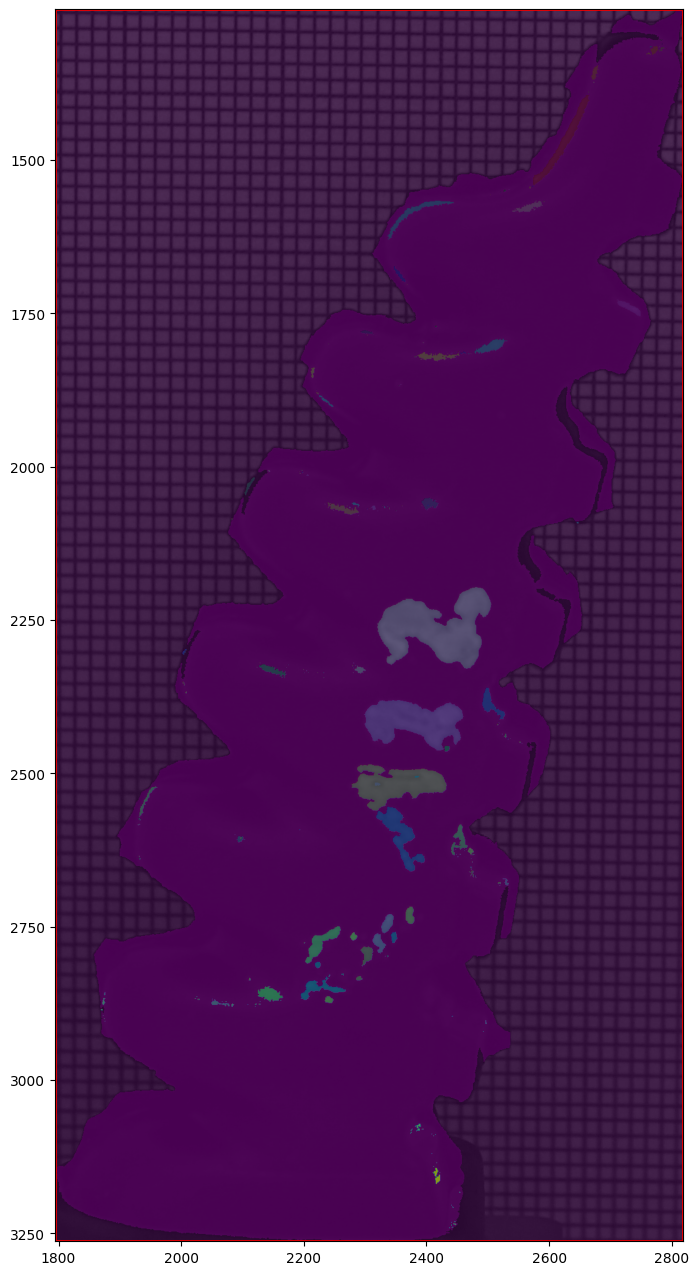

In [12]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(image_label_overlay)
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= label_area:
        # draw rectangle around segmented finger
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Crop and resize the image based on the rectangle's position and size
        scale_factor = 1  # Adjust the scale factor as needed
        cropped_image = asarray(label_image)[int(minr):int(maxr), int(minc):int(maxc)]
        resized_image = zoom(cropped_image, scale_factor)
        ax.imshow(resized_image, extent=(minc, maxc, maxr, minr), alpha=0.5)

Now comes the hard part: Analyzing the image!


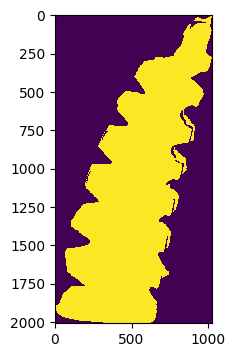

In [13]:
        # Find the coordinates of the first pixel with a value higher than 10
        mask = cropped_image > 2
        fig, ax = plt.subplots(figsize=(3, 4))
        ax.imshow(resized_image)
        plt.pcolormesh(mask)
        mask_indices = np.argwhere(mask)


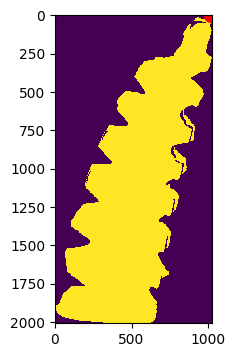

In [14]:
mask = cropped_image > 2
fig, ax = plt.subplots(figsize=(3, 4))
ax.imshow(resized_image)
plt.pcolormesh(mask)
mask_indices = np.argwhere(mask)
if mask_indices.shape[0] > 0:
    # Sort the mask indices based on the sum of row and column in descending order
    sorted_indices = mask_indices[np.argsort((mask_indices[:, 0] + mask_indices[:, 1]))]

    # Sort the mask indices based on the sum of negative row and column in descending order
    sorted_indices = sorted_indices[np.argsort((sorted_indices[:, 0] - sorted_indices[:, 1]))]

    # Get the furthest left and bottom pixel coordinates
    red_pixel = sorted_indices[0]

    # Calculate the coordinates in the original image
    red_pixel_orig = (
        int(red_pixel[1] / scale_factor),
        int(red_pixel[0] / scale_factor)
    )
    # Plot marker on the original image
    ax.plot(*red_pixel_orig, 'ro', markersize=10)

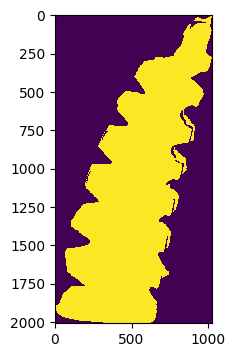

In [15]:
mask = cropped_image > 2
fig, ax = plt.subplots(figsize=(3, 4))
ax.imshow(resized_image)
plt.pcolormesh(mask)
mask_indices = np.argwhere(mask)
if mask_indices.shape[0] > 0:
    # Sort the mask indices based on the column coordinate in ascending order
    sorted_indices = mask_indices[np.argsort(mask_indices[:, 1])]

    # Calculate the number of pixels in the bottom 3% of the mask
    num_pixels_bottom_3_percent = int(mask_indices.shape[0] * 0.03)
    # Calculate the threshold value for filtering
    threshold = mask.shape[0] - mask.shape[0] * 0.03

    # Filter out indices where [0] is lower than the threshold
    mask_indices = mask_indices[mask_indices[:, 0] >= threshold]

    # Get the furthest right pixel coordinates in the bottom 3% of the mask
    furthest_right_bottom_3_percent_pixel = sorted_indices[num_pixels_bottom_3_percent:]

    # Calculate the coordinates in the original image
    blue_pixel = (
        int(mask_indices[0, 1] / scale_factor),
        int(mask_indices[0, 0] / scale_factor)
    )

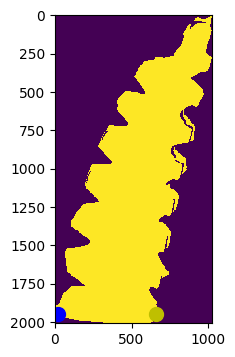

In [16]:
# Plot marker on the original image
fig, ax = plt.subplots(figsize=(3, 4))
ax.imshow(resized_image)
plt.pcolormesh(mask)
ax.plot(*blue_pixel, 'bo', markersize=10)
mask_indices = sorted(mask_indices, key=lambda x: x[1], reverse=True)
last_pixel = mask_indices[0]
yellow_pixel = [1, 2]
yellow_pixel[0] = last_pixel[1]
yellow_pixel[1] = last_pixel[0]
yellow_pixel = asarray(yellow_pixel)
ax.plot(*yellow_pixel, 'yo', markersize=10)

Neues Koordinatensystem zusammenstellen

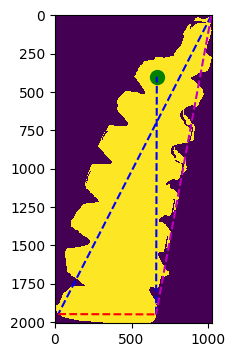

In [17]:
fig, ax = plt.subplots(figsize=(3, 4))
ax.imshow(resized_image)
plt.pcolormesh(mask)

orthogonal_x, orthogonal_y = calculate_orthogonal_line(yellow_pixel[0], yellow_pixel[1], blue_pixel[0], blue_pixel[1], distance=1550)

ax.plot(orthogonal_x, orthogonal_y, 'go', markersize=10)

# Plot the orthogonal line
ax.plot([yellow_pixel[0], orthogonal_x],
        [yellow_pixel[1], orthogonal_y], 'b--')

# Draw lies (yellow-->blue) and (red-->blue)
ax.plot([red_pixel_orig[0], blue_pixel[0]],
        [red_pixel_orig[1], blue_pixel[1]],
        'b--')
ax.plot([blue_pixel[0], yellow_pixel[0]],
        [blue_pixel[1], yellow_pixel[1]],
        'r--')
ax.plot([red_pixel_orig[0], yellow_pixel[0]],
        [red_pixel_orig[1], yellow_pixel[1]],
        'm--')




Calculates the length of the lines and angles

Blue line length: 2190.1146088732435
Magenta line length: 1984.1174360405182
Red line length: 638.003134788537
Ortho line length: 1549.9999999999998
Ortho line 2 length: 1676.170635705088
Angle between red and blue lines: 63.04126916071606
Angle between blue and magenta lines: 16.655277000953355
Angle between red and magenta lines: 100.3034538383306
'Holy angle^^' 89.99999999999999
180.00000000000003
(28.11947485308851, -3.112478135256776)
(1014.8805251469114, 1952.1124781352569)
X-Achse: 34.23725948782453 mm
Y-Achse: 67.31422338397438 mm
Angle between magenta and black lines: 10.303453838330562
Should be right angle: 89.99999999999996
Angle between origin and red: 79.69654616166943
179.99999999999994
saved


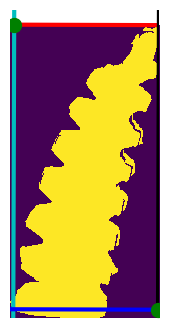

In [24]:
blue_length = calculate_length(red_pixel_orig[0], red_pixel_orig[1], blue_pixel[0], blue_pixel[1])
print("Blue line length:", blue_length)
magenta_length = calculate_length(red_pixel_orig[0], red_pixel_orig[1], yellow_pixel[0], yellow_pixel[1])
print("Magenta line length:", magenta_length)
red_length = calculate_length(yellow_pixel[0], yellow_pixel[1], blue_pixel[0], blue_pixel[1])
print("Red line length:", red_length)
ortho_length = calculate_length(yellow_pixel[0], yellow_pixel[1], orthogonal_x, orthogonal_y)
print("Ortho line length:", ortho_length)
ortho_length2 = calculate_length(blue_pixel[0], blue_pixel[1], orthogonal_x, orthogonal_y)
print("Ortho line 2 length:", ortho_length2)

red_to_blue_angle = cosine_rule(blue_length, red_length, magenta_length)
print("Angle between red and blue lines:", red_to_blue_angle)
blue_to_magenta_angle = cosine_rule(blue_length, magenta_length, red_length)
print("Angle between blue and magenta lines:", blue_to_magenta_angle)
red_to_magenta_angle = cosine_rule(red_length, magenta_length, blue_length)
print("Angle between red and magenta lines:", red_to_magenta_angle)
holy_angle = cosine_rule(red_length, ortho_length, ortho_length2)
print("'Holy angle^^'", holy_angle)
winkel = red_to_magenta_angle + blue_to_magenta_angle + red_to_blue_angle
print(winkel)
orthogonal = (orthogonal_x,  orthogonal_y)

# Calculate the slope of the red line
red_slope = (blue_pixel[1] - yellow_pixel[1]) / (
        blue_pixel[0] - yellow_pixel[0])

# Calculate the slope of the orthogonal line (negative reciprocal)

if red_slope == 0:
    red_slope = 0.0001
ortho_slope = -1 / red_slope

green_slope = (orthogonal_y - yellow_pixel[1]) / (orthogonal_x - yellow_pixel[0])

fig, ax = plt.subplots(figsize=(3, 4))
plt.axline(red_pixel_orig, slope=red_slope, linewidth=3, color='r')
plt.axline(blue_pixel, slope=green_slope, linewidth=3, color='c')
plt.axline(red_pixel_orig, slope=green_slope, linewidth=3, color='k')
plt.axline(blue_pixel, slope=red_slope, linewidth=3, color='b')

intercept1 = intercept(red_pixel_orig, red_slope, blue_pixel, green_slope)
intercept2 = intercept(blue_pixel, red_slope, red_pixel_orig, green_slope)
normalize_factor = calculate_length(yellow_pixel[0], yellow_pixel[1], blue_pixel[0], blue_pixel[1]) / 22
deflection_x = calculate_length(red_pixel_orig[0], red_pixel_orig[1], intercept1[0],
                                intercept1[1]) / normalize_factor
deflection_y = calculate_length(red_pixel_orig[0], red_pixel_orig[1], intercept2[0],
                                intercept2[1]) / normalize_factor
print(intercept1)
print(intercept2)
print(f'X-Achse: {deflection_x} mm')
print(f'Y-Achse: {deflection_y} mm')

finger1_length = calculate_length(*intercept2, *red_pixel_orig)
finger2_length = calculate_length(*intercept2, *yellow_pixel)

finger_angle = cosine_rule(magenta_length, finger1_length, finger2_length)
print("Angle between magenta and black lines:", finger_angle)
finger_angle2 = (cosine_rule(finger1_length, finger2_length, magenta_length))
print("Should be right angle:", finger_angle2)
finger_angle3 = cosine_rule(finger2_length, magenta_length, finger1_length)
print("Angle between origin and red:", finger_angle3)
finger_winkel = finger_angle + finger_angle2 + finger_angle3
print(finger_winkel)


ax.set_axis_off()
ax.plot(*intercept1, 'go', markersize=10)
ax.plot(*intercept2, 'go', markersize=10)

ax.imshow(resized_image)
plt.pcolormesh(mask)
write_to_csv(finger_name, finger_angle2, deflection_x, deflection_y)
processed_dir = r'D:\Nextcloud\00_Promotion\Projekt_Gummifinger\00_Bilder\00_analysis_finger\CSV'
os.makedirs(processed_dir, exist_ok=True)
filename = os.path.join(processed_dir, os.path.basename(finger_name) + '.png')
plt.savefig(filename, bbox_inches='tight')
